In [2]:
pip install web3

  Using cached web3-7.12.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached eth_abi-5.2.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached eth_account-0.13.7-py3-none-any.whl.metadata (3.7 kB)
  Using cached eth_hash-0.7.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached eth_typing-5.2.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached eth_utils-5.3.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached hexbytes-1.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached types_requests-2.32.0.20250602-py3-none-any.whl.metadata (2.1 kB)
  Using cached pyunormalize-16.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
     -------------------------------------- 74.8/74.8 kB 827.4 kB/s eta 0:00:00
  Using cached parsimonious-0.10.0-py3-none-any.whl.metadata (25 kB)
  Using cached eth_keyfile-0.8.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached eth_keys-0.7.0-p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.0.0b4 requires urllib3[secure]~=1.26, but you have urllib3 2.4.0 which is incompatible.
streamlit 1.35.0 requires numpy<2,>=1.19.3, but you have numpy 2.2.4 which is incompatible.
streamlit 1.35.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.0 which is incompatible.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow-intel 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.0 which is incompatible.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.1 which is incompatible.
ydata-profiling 4.16.1 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.4 which is incompatible.

[notice] A new release of pip is available: 24.1.2 -> 25.1.

## Data Extraction

First I extract data from Alchemy using web3 and I extract ethereum and then I extrant only those columns that are neccessary to identify fraud transactions.

In [1]:
from web3 import Web3

In [2]:
import pandas as pd

In [3]:
alchemy_url = "https://eth-mainnet.g.alchemy.com/v2/UDayrGSJGUz1io9sLNi5UuX1v72Op-dP"

w3 = Web3(Web3.HTTPProvider(alchemy_url))


if w3.is_connected():
    print("Connected to ethereum")
else:
    print("Connection failed")

Connected to ethereum


In [4]:
block_range = 10
latest_block = w3.eth.block_number

all_tx = []

for block_num in range(latest_block- block_range, latest_block+1):
    block = w3.eth.get_block(block_num, full_transactions=True)
    
    for tx in block.transactions:
        tx_data = {
            'blockNumber': tx.blockNumber,
            'hash': tx.hash.hex(),
            'from': tx['from'],
            'to': tx['to'],
            'value_eth': w3.from_wei(tx['value'], 'ether'),
            'gas': tx['gas'],
            'gasPrice': w3.from_wei(tx['gasPrice'], 'gwei'),
            
        }
        all_tx.append(tx_data)
        
df = pd.DataFrame(all_tx)
df.to_csv("Ethereum_Transactions.csv", index = False)
print("Saved data")

Saved data


# Converting Raw transaction data into Features per wallet

In [5]:
df = pd.read_csv("Ethereum_Transactions.csv")

In [6]:
df.head()

,blockNumber,hash,from,to,value_eth,gas,gasPrice
0,22665503,c2368a1786d41db0020fa6079e62a6b0ac95563ec8d194...,0xbF7a18C881e971041fCB0D57a679e8944C742edF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.0,126118,42.762324
1,22665503,576a7ca517a4088cb8c25ae4215a06ad2b1868e3323e95...,0x972E6669Aa4D59Bd2aD728cCC59859825e9a6A30,0x3328F7f4A1D1C57c35df56bBf0c9dCAFCA309C49,0.3,467049,5.629499
2,22665503,55e0e1a816c98ac0c6cf80ff53cec1309d886e6a551ab7...,0xa203bbD45a1fE735E595D1D08a8Af350d5da1D67,0x6566194141eefa99Af43Bb5Aa71460Ca2Dc90245,0.0,2066309,1.129499
3,22665503,470178da55e481f70a84ae27fa6df16ef703563ef60bc8...,0x3436d4c549064cfC20769D2a13A6E5FAb29E885F,0xBcb4E4BCc41aB1494A3eb3456ed4Edb8dA5D46E4,0.0,295161,0.748668
4,22665503,b64630dfda70240fc6fc64999c93e14cbe545b730df9c7...,0x953CaeC2BA761a39EAFbfc15A1457431Ff22DB13,0x5BDd6D8C7031cfE862127fDfC6B792c441e49d17,0.0,183610,0.773914


In [7]:
wallet_features = df.groupby("from").agg({"value_eth":["count", "sum", "mean","max"],
                                          "gas":["sum", "mean"],
                                          "gasPrice": "mean",
                                          "to": pd.Series.nunique
                                         })

In [9]:
wallet_features.columns = [
    "tx_count", "total_eth_sent", "avg_tx_value", "max_tx_value",
    "total_gas", "avg_gas", "avg_gas_price", "unique_receivers"
]

wallet_features.reset_index(inplace=True)  # keep 'from' as a column
wallet_features.rename(columns={"from": "wallet_address"}, inplace=True)

In [10]:
wallet_features["gas_per_tx"] = wallet_features["total_gas"] / wallet_features["tx_count"]
wallet_features["value_per_gas"] = wallet_features["total_eth_sent"] / wallet_features["total_gas"]

In [11]:
print(wallet_features.columns.tolist())

['wallet_address', 'tx_count', 'total_eth_sent', 'avg_tx_value', 'max_tx_value', 'total_gas', 'avg_gas', 'avg_gas_price', 'unique_receivers', 'gas_per_tx', 'value_per_gas']


In [12]:
wallet_features.head()

,wallet_address,tx_count,total_eth_sent,avg_tx_value,max_tx_value,total_gas,avg_gas,avg_gas_price,unique_receivers,gas_per_tx,value_per_gas
0,0x000010BBf2aA8844A209ec6e310F4B91B54a651F,1,1.000000e-10,1.000000e-10,1.000000e-10,21000,21000.0,0.677063,1,21000.0,4.761905e-15
1,0x0000db5c8B030ae20308ac975898E09741e70000,1,0.000000e+00,0.000000e+00,0.000000e+00,474600,474600.0,2.649041,1,474600.0,0.000000e+00
2,0x00220b36fDF0BC0684705Af92D52E088647Ee662,1,4.023335e-02,4.023335e-02,4.023335e-02,21000,21000.0,1.067964,1,21000.0,1.915874e-06
3,0x009a56884bb7e29b3bDe485FDE2Db453c5761D4e,1,0.000000e+00,0.000000e+00,0.000000e+00,200000,200000.0,0.651751,1,200000.0,0.000000e+00
4,0x00D05E7d46Bfc57C438A10c699C77Bf6fa183D63,1,1.330597e-02,1.330597e-02,1.330597e-02,21000,21000.0,0.688663,1,21000.0,6.336177e-07


In [13]:
wallet_features.isnull().sum()

wallet_address      0
tx_count            0
total_eth_sent      0
avg_tx_value        0
max_tx_value        0
total_gas           0
avg_gas             0
avg_gas_price       0
unique_receivers    0
gas_per_tx          0
value_per_gas       0
dtype: int64

In [14]:
wallet_features.describe()

,tx_count,total_eth_sent,avg_tx_value,max_tx_value,total_gas,avg_gas,avg_gas_price,unique_receivers,gas_per_tx,value_per_gas
count,1637.000000,1637.000000,1637.000000,1637.000000,1.637000e+03,1.637000e+03,1637.000000,1637.000000,1.637000e+03,1.637000e+03
mean,1.444105,0.271932,0.209464,0.265053,2.764805e+05,1.874112e+05,1.396809,1.258400,1.874112e+05,4.889591e-06
std,3.514390,2.892310,2.100790,2.883552,1.030116e+06,5.599540e+05,1.880108,2.666199,5.599540e+05,4.685820e-05
min,1.000000,0.000000,0.000000,0.000000,2.100000e+04,2.100000e+04,0.620711,0.000000,2.100000e+04,0.000000e+00
25%,1.000000,0.000000,0.000000,0.000000,4.836600e+04,4.608500e+04,0.674922,1.000000,4.608500e+04,0.000000e+00
50%,1.000000,0.000000,0.000000,0.000000,7.500000e+04,6.971800e+04,0.979716,1.000000,6.971800e+04,0.000000e+00
75%,1.000000,0.002500,0.002300,0.002399,2.475860e+05,2.000000e+05,1.600000,1.000000,2.000000e+05,2.285714e-08
max,123.000000,80.186455,53.102732,80.170319,2.400000e+07,1.200000e+07,42.762324,104.000000,1.200000e+07,1.062055e-03


## Anomaly Detection

In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [25]:
features = wallet_features[['tx_count', 'total_eth_sent','avg_tx_value', 'avg_gas', 'avg_gas_price', 'unique_receivers', 'gas_per_tx', 'value_per_gas','max_tx_value']]

In [26]:
features.isnull().sum()

tx_count            0
total_eth_sent      0
avg_tx_value        0
avg_gas             0
avg_gas_price       0
unique_receivers    0
gas_per_tx          0
value_per_gas       0
max_tx_value        0
dtype: int64

In [21]:
#Normailize the data

In [22]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)

In [24]:
x_scaled

array([[-0.12640622, -0.09404768, -0.29727818, ..., -0.09694643,
        -0.29727818, -0.10438055],
       [-0.12640622, -0.09404768,  0.51303597, ..., -0.09694643,
         0.51303597, -0.10438055],
       [-0.12640622, -0.08013298, -0.29727818, ..., -0.09694643,
        -0.29727818, -0.06348142],
       ...,
       [-0.12640622, -0.09404768, -0.26359191, ..., -0.09694643,
        -0.26359191, -0.10438055],
       [-0.12640622, -0.09404768, -0.23667611, ..., -0.09694643,
        -0.23667611, -0.10438055],
       [-0.12640622, -0.09121533, -0.29727818, ..., -0.09694643,
        -0.29727818, -0.09605547]], shape=(1637, 7))

### Train the model

In [27]:
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

In [28]:
model.fit(x_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [29]:
wallet_features['anomaly_score'] = model.decision_function(x_scaled)

In [30]:
wallet_features['anomaly'] = model.predict(x_scaled)

In [37]:
wallet_features['anomaly'].value_counts()

anomaly
 1    1555
-1      82
Name: count, dtype: int64

In [38]:
#Filtering suspicious wallets

In [39]:
suspicious_wallets = wallet_features[wallet_features['anomaly']==-1]

In [40]:
suspicious_wallets = suspicious_wallets.sort_values(by = 'anomaly_score')

In [42]:
print(suspicious_wallets[['wallet_address', 'tx_count', 'total_eth_sent', 'anomaly_score']].head(10))

                                  wallet_address  tx_count  total_eth_sent  \
158   0x19F00b3a7B6F55C9dA966FE3723251784a797fa7         1       53.102732   
1601  0xf70da97812CB96acDF810712Aa562db8dfA3dbEF       123        1.480649   
279   0x2f13d388b85e0eCd32e7C3D7F36D1053354EF104         1       50.000000   
1232  0xE39c2460304cD4dD5B229A96d201348bd4FDBd9e         1       10.759756   
759   0x77134cbC06cB00b66F4c7e623D5fdBF6777635EC         3       80.186455   
681   0x6Fb8d531294Cdd7D664D25589917196975444310         1       12.000000   
1584  0xf1123eD4DF7E06C800c85a3ce63bCC886E504a14         1        6.999634   
212   0x22e2aA72Ac043E3e28784cFeEE134b1Da465DaBb         1       10.234300   
427   0x46340b20830761efd32832A74d7169B29FEB9758         7        9.433214   
482   0x4ddD5615a180fB21307d71FFB6a9Dbe7c9aA68f7         2       26.500000   

      anomaly_score  
158       -0.240754  
1601      -0.225620  
279       -0.225102  
1232      -0.224146  
759       -0.211829  
681      

In [43]:
#Visualizing the Anomaly Score Distribution

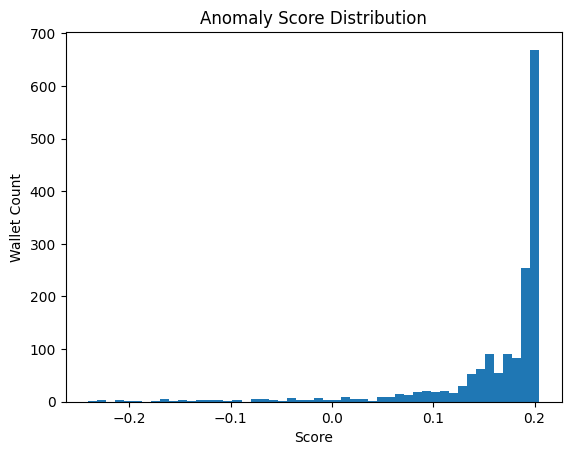

In [45]:
plt.hist(wallet_features['anomaly_score'], bins=50)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.show()

We'll see a cluster near zero and a tail going negative- that tail is suspicious group.

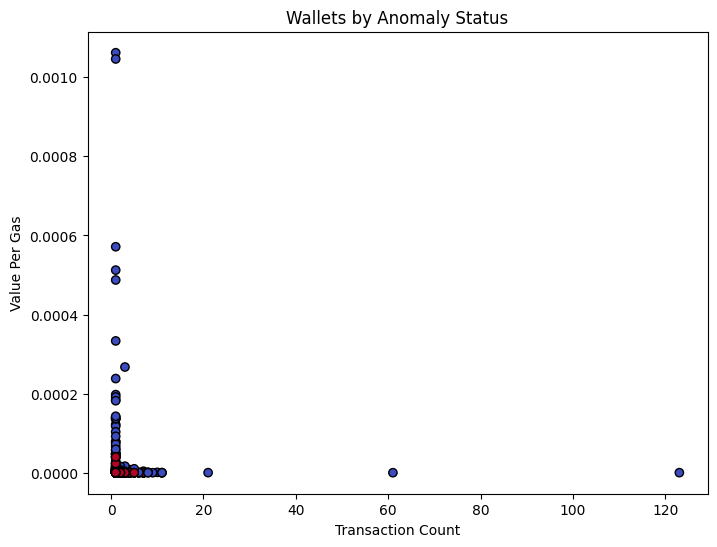

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(wallet_features['tx_count'],
           wallet_features['value_per_gas'],
           c = wallet_features['anomaly'],
           cmap = 'coolwarm', edgecolors='k')
plt.xlabel("Transaction Count")
plt.ylabel("Value Per Gas")
plt.title("Wallets by Anomaly Status")
plt.show()


Red dots(anomaly = -1) will show us where abnormal behaviour clusters. 

In [47]:
suspicious_wallets.to_csv("flagged_wallets.csv", index = False)

In [48]:
flag = pd.read_csv("flagged_wallets.csv")

In [56]:
flag.head()

,wallet_address,tx_count,total_eth_sent,avg_tx_value,max_tx_value,total_gas,avg_gas,avg_gas_price,unique_receivers,gas_per_tx,value_per_gas,anomaly_score,anomaly
0,0x19F00b3a7B6F55C9dA966FE3723251784a797fa7,1,53.102732,53.102732,53.102732,50000,50000.000000,2.000000,1,50000.000000,1.062055e-03,-0.240754,-1
1,0xf70da97812CB96acDF810712Aa562db8dfA3dbEF,123,1.480649,0.012038,0.994540,8242755,67014.268293,1.279090,104,67014.268293,1.796303e-07,-0.225620,-1
2,0x2f13d388b85e0eCd32e7C3D7F36D1053354EF104,1,50.000000,50.000000,50.000000,47790,47790.000000,0.639499,1,47790.000000,1.046244e-03,-0.225102,-1
3,0xE39c2460304cD4dD5B229A96d201348bd4FDBd9e,1,10.759756,10.759756,10.759756,21000,21000.000000,5.000000,1,21000.000000,5.123694e-04,-0.224146,-1
4,0x77134cbC06cB00b66F4c7e623D5fdBF6777635EC,3,80.186455,26.728818,80.170319,300000,100000.000000,0.983425,3,100000.000000,2.672882e-04,-0.211829,-1


## Bonus Analysis

In [52]:
import pandas as pd

data = {
    "label": ["TornadoCash", "FTXExploiter", "MultichainBridge"],
    "address": [
        "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3",
        "0x5a1cf781c1e80e468fbc5cf1974b6b6f84b18e3b",
        "0x1234567890abcdef1234567890abcdef12345678"
    ]
}

df = pd.DataFrame(data)
df.to_csv("blacklist.csv", index=False)

Implementing this in our pipeline 

In [58]:
import pandas as pd
wallets = pd.read_csv('flagged_wallets.csv') #Loading flaggedwallets.csv
wallets['wallet_address'] = wallets['wallet_address'].str.lower()

In [59]:
wallets['wallet_address']

0     0x19f00b3a7b6f55c9da966fe3723251784a797fa7
1     0xf70da97812cb96acdf810712aa562db8dfa3dbef
2     0x2f13d388b85e0ecd32e7c3d7f36d1053354ef104
3     0xe39c2460304cd4dd5b229a96d201348bd4fdbd9e
4     0x77134cbc06cb00b66f4c7e623d5fdbf6777635ec
                         ...                    
77    0xdbf79adf5af85d01ff4136cae6e9853188941533
78    0xf7d44d5a28d5af27a7f9c8fc6efe0129e554d7c4
79    0xa203bbd45a1fe735e595d1d08a8af350d5da1d67
80    0xc6ce6d2c923835b3de5f23c63d1676f97d99c83e
81    0xdf5ba7d7d46363612301cd55be583d606995cb95
Name: wallet_address, Length: 82, dtype: object

In [60]:
blacklist = pd.read_csv('blacklist.csv')  # Load blacklist.csv
blacklist['address'] = blacklist['address'].str.lower()

In [62]:
label_map = dict(zip(blacklist['address'], blacklist['label']))
wallets['risk_label'] = wallets['wallet_address'].map(label_map) 
#Now we can see if our flagged wallet = a known malicious wallet

In [63]:
#Finding wallets that interacted with risky address

In [64]:
tx_data = pd.read_csv('Ethereum_Transactions.csv')

In [65]:
tx_data['from'] = tx_data['from'].str.lower()
tx_data['to'] = tx_data['to'].str.lower()

In [66]:
#Filtering for suspiscious wallets sending funds to blacklisted addresses

In [67]:
flagged_wallets = wallets[wallets['anomaly'] == -1]
interactions = tx_data[
    (tx_data['from'].isin(flagged_wallets['wallet_address'])) & 
    (tx_data['to'].isin((blacklist['address'])))
]

In [68]:
interactions = interactions.merge(blacklist, left_on='to', right_on='address', how='left') #join to add labels

In [69]:
#Merging risk insights back to our flagged wallets table

In [70]:
wallets['interacted_with_risky'] = wallets['wallet_address'].isin(interactions['from'])

In [71]:
wallets

,wallet_address,tx_count,total_eth_sent,avg_tx_value,max_tx_value,total_gas,avg_gas,avg_gas_price,unique_receivers,gas_per_tx,value_per_gas,anomaly_score,anomaly,risk_label,interacted_with_risky
0,0x19f00b3a7b6f55c9da966fe3723251784a797fa7,1,5.310273e+01,5.310273e+01,5.310273e+01,50000,5.000000e+04,2.000000,1,5.000000e+04,1.062055e-03,-0.240754,-1,NaN,False
1,0xf70da97812cb96acdf810712aa562db8dfa3dbef,123,1.480649e+00,1.203780e-02,9.945404e-01,8242755,6.701427e+04,1.279090,104,6.701427e+04,1.796303e-07,-0.225620,-1,NaN,False
2,0x2f13d388b85e0ecd32e7c3d7f36d1053354ef104,1,5.000000e+01,5.000000e+01,5.000000e+01,47790,4.779000e+04,0.639499,1,4.779000e+04,1.046244e-03,-0.225102,-1,NaN,False
3,0xe39c2460304cd4dd5b229a96d201348bd4fdbd9e,1,1.075976e+01,1.075976e+01,1.075976e+01,21000,2.100000e+04,5.000000,1,2.100000e+04,5.123694e-04,-0.224146,-1,NaN,False
4,0x77134cbc06cb00b66f4c7e623d5fdbf6777635ec,3,8.018645e+01,2.672882e+01,8.017032e+01,300000,1.000000e+05,0.983425,3,1.000000e+05,2.672882e-04,-0.211829,-1,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0xdbf79adf5af85d01ff4136cae6e9853188941533,1,1.301000e-14,1.301000e-14,1.301000e-14,1999998,1.999998e+06,0.662081,1,1.999998e+06,6.505007e-21,-0.010352,-1,NaN,False
78,0xf7d44d5a28d5af27a7f9c8fc6efe0129e554d7c4,1,0.000000e+00,0.000000e+00,0.000000e+00,2063023,2.063023e+06,1.120711,1,2.063023e+06,0.000000e+00,-0.008834,-1,NaN,False
79,0xa203bbd45a1fe735e595d1d08a8af350d5da1d67,1,0.000000e+00,0.000000e+00,0.000000e+00,2066309,2.066309e+06,1.129499,1,2.066309e+06,0.000000e+00,-0.008834,-1,NaN,False
80,0xc6ce6d2c923835b3de5f23c63d1676f97d99c83e,1,0.000000e+00,0.000000e+00,0.000000e+00,1789310,1.789310e+06,0.831335,0,1.789310e+06,0.000000e+00,-0.008617,-1,NaN,False


In [72]:
wallets.isnull().sum()

wallet_address            0
tx_count                  0
total_eth_sent            0
avg_tx_value              0
max_tx_value              0
total_gas                 0
avg_gas                   0
avg_gas_price             0
unique_receivers          0
gas_per_tx                0
value_per_gas             0
anomaly_score             0
anomaly                   0
risk_label               82
interacted_with_risky     0
dtype: int64